Mixture GAN (CIFAR10)

In [1]:
device = "cuda:0"

time_sampler = 0.2
inverse_logs = False
discriminator_iters = 1
num_steps = 10

name = f"mixture-gan-normal-cifar-{time_sampler}-{inverse_logs}-{discriminator_iters}"

Set environment

In [2]:
import numpy as np
import torch as th
import random

seed = 42

th.manual_seed(42)
if th.cuda.is_available():
    th.cuda.manual_seed(seed)

np.random.seed(42)
random.seed(42)

Create datalooper

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

def infiniteloop(dataloader):
    while True:
        for x, y in iter(dataloader):
            yield x

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist_dataset = MNIST(root="data", train=True, download=True, transform=transform)
train_mnist_loader = DataLoader(train_mnist_dataset, batch_size=256, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)
train_mnist_looper = infiniteloop(train_mnist_loader)

Define models

In [4]:
import torch.nn as nn
import torch as th

class Generator(nn.Module):
    def __init__(self, latent_dim=128, hidden_dim=64):
        super().__init__()

        self.latent_dim = latent_dim

        self.proj = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_dim * 4 * 7 * 7),
            nn.ReLU()
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, *(3, 2, 1, 1)),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, *(3, 1, 1)),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),

            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, *(3, 2, 1, 1)),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),

            nn.Conv2d(hidden_dim, 1, *(3, 1, 1))
        )

    def forward(self, z):
        inp = self.proj(z).reshape(z.shape[0], -1, 7, 7)
        return th.tanh(self.model(inp))
    
    def sample(self, k, device):
        z = th.randn(k, self.latent_dim, device=device)
        return self.forward(z)

class Discriminator(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, hidden_dim, *(3, 2, 1)),
            nn.LeakyReLU(),

            nn.Conv2d(hidden_dim, hidden_dim, *(3, 1, 1)),
            nn.LeakyReLU(),

            nn.Conv2d(hidden_dim, hidden_dim * 2, *(3, 2, 1)),
            nn.LeakyReLU(),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, *(3, 1, 1)),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1)
        )
    
    def forward(self, x):
        return th.sigmoid(self.model(x))

In [5]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print("Generator params:", np.sum([np.prod(p.shape) for p in generator.parameters()]))
print("Discriminator params:", np.sum([np.prod(p.shape) for p in discriminator.parameters()]))

Generator params: 2135809
Discriminator params: 68129


In [6]:
def sample_time(k, time_sampler):
    return th.ones(k, device=device, dtype=th.int32) * time_sampler

Training

In [7]:
import wandb

run = wandb.init(project="gans", name=name)

run.config.device = device
run.config.time_sampler = time_sampler
run.config.inverse_logs = inverse_logs
run.config.discriminator_iters = discriminator_iters
run.config.num_steps = num_steps

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tixmav to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
generator_opt = th.optim.AdamW(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
discriminator_opt = th.optim.AdamW(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [9]:
max_steps = 50000 + 1

Step 50000


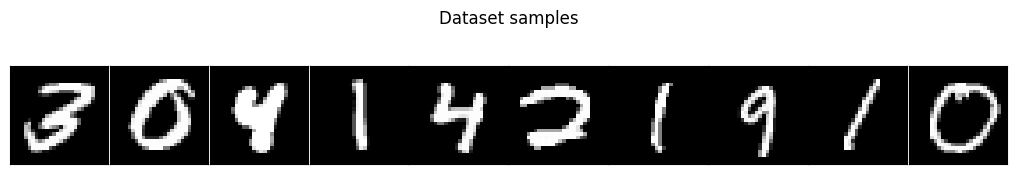

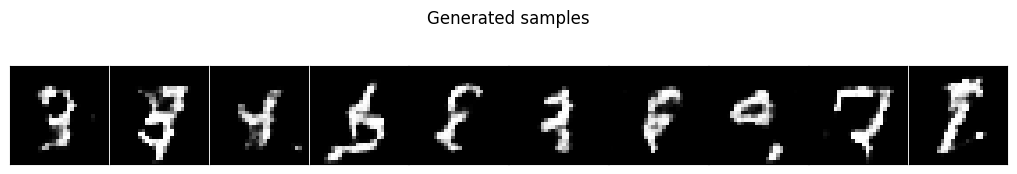

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch.nn.functional as F

def plot_images(batch_x, title):
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    if title is not None:
        fig.suptitle(title)
    for i in range(10):
        axes[i].imshow(batch_x[i].squeeze(), cmap="gray")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)
    plt.show()

step_stat = {
    "generator loss": [],
    "discriminator loss": []
}

for step in range(1, max_steps + 1):
    # discriminator optimization
    discriminator.train(True); generator.eval()

    for _ in range(discriminator_iters):
        x_true = next(train_mnist_looper).to(device)
        t = sample_time(x_true.shape[0], time_sampler=time_sampler)

        x_fake = generator.sample(x_true.shape[0], device)

        normal = th.randn_like(x_true)

        t_ = t.reshape(-1, 1, 1, 1)

        true_mixture = x_true * t_ + normal * (1 - t_)
        fake_mixture = x_fake * t_ + normal * (1 - t_)

        true_disc = discriminator(x=true_mixture)
        fake_disc = discriminator(x=fake_mixture)

        loss = F.binary_cross_entropy(fake_disc, th.zeros_like(fake_disc)) + F.binary_cross_entropy(true_disc, th.ones_like(true_disc))
        
        step_stat["discriminator loss"].append(loss.item())
        discriminator_opt.zero_grad(); loss.backward(); discriminator_opt.step()

    # generator optimization
    discriminator.eval(); generator.train(True)
    
    x_fake = generator.sample(x_true.shape[0], device)

    normal = th.randn_like(x_true)

    t_ = t.reshape(-1, 1, 1, 1)

    true_mixture = x_true * t_ + normal * (1 - t_)
    fake_mixture = x_fake * t_ + normal * (1 - t_)

    true_disc = discriminator(x=true_mixture)
    fake_disc = discriminator(x=fake_mixture)

    if inverse_logs:
        loss = F.binary_cross_entropy(fake_disc, th.ones_like(fake_disc)) + F.binary_cross_entropy(true_disc, th.zeros_like(true_disc))
    else:
        loss = -F.binary_cross_entropy(fake_disc, th.zeros_like(fake_disc)) - F.binary_cross_entropy(true_disc, th.ones_like(true_disc))

    step_stat["generator loss"] = loss.item()
    generator_opt.zero_grad(); loss.backward(); generator_opt.step()

    # Plots
    discriminator.eval(); generator.eval()
        
    if step % 50 == 0:
        step_stat["generator loss"] = np.mean(step_stat["generator loss"])
        step_stat["discriminator loss"] = np.mean(step_stat["discriminator loss"])
        step_stat["step"] = step

        run.log(step_stat)

        step_stat = {
            "generator loss": [],
            "discriminator loss": []
        }

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        plot_images(x_true[:10].to("cpu"), "Dataset samples")
        plot_images(x_fake[:10].detach().cpu(), "Generated samples")

---